#### Hybrid PCA-Autoencoder-CNN model for portfolio optimization, integrating PCA initialization with autoencoder training and CNN prediction:


The purpose of this hybrid PCA–autoencoder–CNN approach is to leverage the strengths of both linear and non-linear dimensionality reduction techniques in order to extract the most informative features from high-dimensional financial data before portfolio optimization. First, Principal Component Analysis (PCA) is used to reduce noise and compress the data by capturing the most significant linear relationships, which helps mitigate the curse of dimensionality and improves interpretability. Next, an autoencoder further refines this representation by learning non-linear patterns and hierarchical features that PCA cannot capture, resulting in more robust and informative latent factors. These compressed features are then used as input to a convolutional neural network (CNN), which learns to construct optimal portfolio weights based on the extracted factors. This integrated pipeline aims to improve model performance, reduce overfitting, and enhance the ability to uncover complex relationships in financial markets, ultimately supporting more effective and adaptive portfolio optimization.

Related
What is the main goal of using autoencoders in data compression and noise reduction
How do autoencoders help in capturing essential features from complex data
Why are regularization techniques like contractive autoencoders important for model robustness
In what ways do denoising autoencoders improve data quality for machine learning tasks
How does understanding the purpose of autoencoders enhance their application in various fields


- Loading the dataset

In [20]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time
import os
import psutil

# --- Memory tracking functions ---
def get_memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / (1024 ** 3)  # in GB

def get_gpu_memory():
    if torch.cuda.is_available():
        return torch.cuda.memory_allocated() / (1024 ** 3)  # in GB
    return 0

# --- Timer context manager ---
class Timer:
    def __enter__(self):
        self.start_time = time.time()
        return self
    
    def __exit__(self, *args):
        self.end_time = time.time()
        self.duration = self.end_time - self.start_time

# --- Data Loading and Preprocessing ---
print("Starting data loading...")
data_load_start = time.time()

data = pd.read_csv('/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Final_csv/5e-standardized_dataset.csv')
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')
data = data.dropna(subset=['Date'])
data = data.sort_values(['Date', 'Ticker']).reset_index(drop=True)

assets = ['ARKK', 'AGG', 'GLD', 'HYG', 'SPY', 'USO', 'VNQ', 'VXUS']
features = ['returns',
       'EMA_10']
lookback = 20

# Create sequences and targets
X_list, y_list, dates_list = [], [], []
all_dates = sorted(data['Date'].unique())

for i in range(lookback, len(data)):
    cur_date = data.iloc[i]['Date']
    day_slice = data[data['Date'] == cur_date]
    if set(assets) <= set(day_slice['Ticker']):
        X_i = []
        valid = True
        for asset in assets:
            asset_slice = data[(data['Ticker'] == asset) & (data['Date'] <= cur_date)].tail(lookback)
            if len(asset_slice) == lookback:
                X_i.append(asset_slice[features].values)
            else:
                valid = False
                break
        if valid:
            # Get next day returns
            cur_idx = all_dates.index(cur_date)
            if cur_idx + 1 < len(all_dates):
                next_date = all_dates[cur_idx + 1]
                next_returns = []
                for asset in assets:
                    next_row = data[(data['Date'] == next_date) & (data['Ticker'] == asset)]
                    if not next_row.empty:
                        next_returns.append(next_row['returns'].values[0])
                    else:
                        valid = False
                        break
                if valid:
                    X_i = np.stack(X_i, axis=1)  # (lookback, n_assets, n_features)
                    X_list.append(X_i)
                    y_list.append(next_returns)
                    dates_list.append(cur_date)

X = np.array(X_list)  # (samples, lookback, n_assets, n_features)
y = np.array(y_list)
dates = np.array(dates_list)

data_load_time = time.time() - data_load_start
print(f"Data loaded in {data_load_time:.2f} seconds, shape: {X.shape}")

# --- Hybrid Dimensionality Reduction: PCA + Autoencoder ---
print("\nStarting dimensionality reduction...")
dim_red_start = time.time()

# Reshape and standardize
samples, lb, n_assets, n_features = X.shape
X_flat = X.reshape(-1, n_features)

with Timer() as t_scaler:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_flat)
scaler_time = t_scaler.duration

# Apply PCA
with Timer() as t_pca:
    pca = PCA(n_components=0.95)
    X_pca = pca.fit_transform(X_scaled)
    pca_dims = X_pca.shape[1]
pca_time = t_pca.duration
print(f"PCA reduced dimensions to {pca_dims} in {pca_time:.2f}s")

# Autoencoder on PCA output
class PCAEnhancedAE(nn.Module):
    def __init__(self, input_dim, latent_dim=6):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )
    
    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

# Initialize and train autoencoder
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ae_model = PCAEnhancedAE(pca_dims, latent_dim=6).to(device)
optimizer = optim.Adam(ae_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

X_pca_tensor = torch.tensor(X_pca, dtype=torch.float32).to(device)

# Autoencoder training
print("Training autoencoder...")
ae_train_start = time.time()
ae_losses = []
for epoch in range(50):
    epoch_start = time.time()
    optimizer.zero_grad()
    recon, latent = ae_model(X_pca_tensor)
    loss = criterion(recon, X_pca_tensor)
    loss.backward()
    optimizer.step()
    ae_losses.append(loss.item())
    
    if epoch % 10 == 0:
        epoch_time = time.time() - epoch_start
        print(f'Epoch {epoch}: Loss={loss.item():.6f}, Time={epoch_time:.2f}s')

ae_train_time = time.time() - ae_train_start
print(f"Autoencoder trained in {ae_train_time:.2f} seconds")

# Extract latent representations
ae_model.eval()
with torch.no_grad():
    _, latent_vectors = ae_model(X_pca_tensor)
    latent_vectors = latent_vectors.cpu().numpy()

# Reshape for CNN input
latent_reshaped = latent_vectors.reshape(samples, lb, n_assets, -1)
X_cnn = latent_reshaped.reshape(samples, lb, n_assets * latent_reshaped.shape[-1])

dim_red_time = time.time() - dim_red_start
print(f"Dimensionality reduction completed in {dim_red_time:.2f} seconds")
print(f"Final CNN input shape: {X_cnn.shape}")

# --- CNN Model Definition ---
class PortfolioCNN(nn.Module):
    def __init__(self, input_channels, lookback, n_assets, latent_dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3, 1), padding=(1, 0)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 1)),
            nn.Conv2d(16, 32, kernel_size=(3, 1), padding=(1, 0)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 1))
        )
        with torch.no_grad():
            self.flattened_size = self.conv(torch.zeros(1, 1, lookback, n_assets * latent_dim)).numel()
        
        self.fc = nn.Sequential(
            nn.Linear(self.flattened_size, 64),
            nn.ReLU(),
            nn.Linear(64, n_assets)
        )
    
    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return torch.softmax(x, dim=1)

# --- Training Setup ---
print("\nPreparing CNN training...")
X_tensor = torch.tensor(X_cnn, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Train/test split
split_idx = int(0.7 * len(X_tensor))
X_train, X_test = X_tensor[:split_idx], X_tensor[split_idx:]
y_train, y_test = y_tensor[:split_idx], y_tensor[split_idx:]
train_dates, test_dates = dates[:split_idx], dates[split_idx:]

print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")

# Initialize CNN
n_assets = len(assets)
latent_dim = latent_reshaped.shape[-1]
cnn_model = PortfolioCNN(1, lookback, n_assets, latent_dim)
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# --- Portfolio Evaluation Functions ---
def sharpe_loss(portfolio_returns):
    return -torch.mean(portfolio_returns) / (torch.std(portfolio_returns) + 1e-6)

def evaluate_portfolio(model, X, y, dates, cost_rate=0.0005):
    model.eval()
    portfolio_values = [1.0]
    weights_history = []
    returns = []
    prev_weights = None
    
    with torch.no_grad():
        for i in range(len(X)):
            current_X = X[i].unsqueeze(0)
            current_y = y[i]
            weights = model(current_X)
            raw_return = torch.sum(weights * current_y).item()
            
            if prev_weights is not None:
                turnover = torch.sum(torch.abs(weights - prev_weights)).item()
                raw_return -= cost_rate * turnover
            
            portfolio_values.append(portfolio_values[-1] * (1 + raw_return))
            weights_history.append(weights.squeeze().cpu().numpy())
            returns.append(raw_return)
            prev_weights = weights.clone()
    
    returns = np.array(returns)
    portfolio_values = np.array(portfolio_values)
    sharpe = np.mean(returns) / (np.std(returns) + 1e-9)
    
    # Calculate max drawdown
    peak = np.maximum.accumulate(portfolio_values)
    drawdown = (peak - portfolio_values) / peak
    max_drawdown = np.max(drawdown)
    
    # Annualized metrics
    ann_return = (portfolio_values[-1] / portfolio_values[0]) ** (252 / len(returns)) - 1
    ann_vol = np.std(returns) * np.sqrt(252)
    
    return {
        'sharpe': sharpe,
        'max_drawdown': max_drawdown,
        'annualized_return': ann_return,
        'annualized_vol': ann_vol,
        'cumulative_returns': portfolio_values,
        'weights': np.array(weights_history),
        'dates': dates
    }

# --- Training Loop ---
print("\nTraining CNN model...")
cnn_train_start = time.time()
sharpe_ratios = []
for epoch in range(50):
    epoch_start = time.time()
    optimizer.zero_grad()
    weights = cnn_model(X_train)
    portfolio_returns = torch.sum(weights * y_train, dim=1)
    loss = sharpe_loss(portfolio_returns)
    loss.backward()
    optimizer.step()
    
    # Record training Sharpe ratio
    with torch.no_grad():
        train_sharpe = -loss.item()
        sharpe_ratios.append(train_sharpe)
    
    epoch_time = time.time() - epoch_start
    if epoch % 10 == 0:
        print(f'Epoch {epoch}: Sharpe={train_sharpe:.4f}, Time={epoch_time:.2f}s')

cnn_train_time = time.time() - cnn_train_start
print(f"CNN trained in {cnn_train_time:.2f} seconds")

# --- Evaluation ---
print("\nEvaluating portfolio performance...")
eval_start = time.time()

# Evaluate on train and test sets
train_results = evaluate_portfolio(cnn_model, X_train, y_train, train_dates)
test_results = evaluate_portfolio(cnn_model, X_test, y_test, test_dates)

eval_time = time.time() - eval_start
print(f"Evaluation completed in {eval_time:.2f} seconds")

# --- Performance Metrics Report ---
print("\n" + "="*60)
print("Performance Metrics Report")
print("="*60)

# Resource Utilization
print("\nResource Utilization:")
print(f"- Data loading time: {data_load_time:.2f}s")
print(f"- Scaling time: {scaler_time:.2f}s")
print(f"- PCA time: {pca_time:.2f}s")
print(f"- Autoencoder training time: {ae_train_time:.2f}s")
print(f"- CNN training time: {cnn_train_time:.2f}s")
print(f"- Evaluation time: {eval_time:.2f}s")

if torch.cuda.is_available():
    print(f"- GPU memory used: {get_gpu_memory():.2f} GB")
print(f"- RAM usage: {get_memory_usage():.2f} GB")

# Autoencoder Performance
print("\nAutoencoder Performance:")
print(f"- Final training loss (MSE): {ae_losses[-1]:.6f}")
print(f"- Latent dimension: {latent_dim}")
print(f"- Parameters: {sum(p.numel() for p in ae_model.parameters()):,}")

# Portfolio Performance
def print_portfolio_metrics(name, results):
    print(f"\n{name} Portfolio Performance:")
    print(f"- Sharpe Ratio: {results['sharpe']:.2f}")
    print(f"- Annualized Return: {results['annualized_return']:.2%}")
    print(f"- Annualized Volatility: {results['annualized_vol']:.2%}")
    print(f"- Maximum Drawdown: {results['max_drawdown']:.2%}")

print_portfolio_metrics("Training", train_results)
print_portfolio_metrics("Test", test_results)

print("\n" + "="*60)

# --- Save Results ---
results_df = pd.DataFrame({
    'Date': test_dates,
    'Cumulative_Return': test_results['cumulative_returns'][1:]
})
for i, asset in enumerate(assets):
    results_df[f'Weight_{asset}'] = test_results['weights'][:, i]
results_df.to_csv('portfolio_results.csv', index=False)
print("Results saved to portfolio_results.csv")


Starting data loading...
Data loaded in 291.82 seconds, shape: (17864, 20, 8, 2)

Starting dimensionality reduction...
PCA reduced dimensions to 2 in 0.10s
Training autoencoder...
Epoch 0: Loss=1.006828, Time=3.41s
Epoch 10: Loss=0.958382, Time=1.87s
Epoch 20: Loss=0.828029, Time=2.06s
Epoch 30: Loss=0.670677, Time=1.80s
Epoch 40: Loss=0.573438, Time=1.70s
Autoencoder trained in 98.88 seconds
Dimensionality reduction completed in 99.75 seconds
Final CNN input shape: (17864, 20, 48)

Preparing CNN training...
Train samples: 12504, Test samples: 5360

Training CNN model...
Epoch 0: Sharpe=0.0150, Time=4.74s
Epoch 10: Sharpe=0.1485, Time=3.82s
Epoch 20: Sharpe=0.2622, Time=3.90s
Epoch 30: Sharpe=0.3673, Time=4.23s
Epoch 40: Sharpe=0.4218, Time=4.32s
CNN trained in 205.19 seconds

Evaluating portfolio performance...


/var/folders/4r/xd1m46rs2r1gx3mmpw3z84pw0000gn/T/ipykernel_87746/1984222586.py:257: RuntimeWarning: invalid value encountered in subtract
  drawdown = (peak - portfolio_values) / peak
/var/folders/4r/xd1m46rs2r1gx3mmpw3z84pw0000gn/T/ipykernel_87746/1984222586.py:257: RuntimeWarning: invalid value encountered in divide
  drawdown = (peak - portfolio_values) / peak


Evaluation completed in 5.56 seconds

Performance Metrics Report

Resource Utilization:
- Data loading time: 291.82s
- Scaling time: 0.17s
- PCA time: 0.10s
- Autoencoder training time: 98.88s
- CNN training time: 205.19s
- Evaluation time: 5.56s
- RAM usage: 0.30 GB

Autoencoder Performance:
- Final training loss (MSE): 0.452397
- Latent dimension: 6
- Parameters: 4,936

Training Portfolio Performance:
- Sharpe Ratio: 0.47
- Annualized Return: inf%
- Annualized Volatility: 1192.97%
- Maximum Drawdown: nan%

Test Portfolio Performance:
- Sharpe Ratio: -0.05
- Annualized Return: -100.00%
- Annualized Volatility: 1514.13%
- Maximum Drawdown: 100.00%

Results saved to portfolio_results.csv


- Visualization

In [10]:
# --- Visualization ---
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

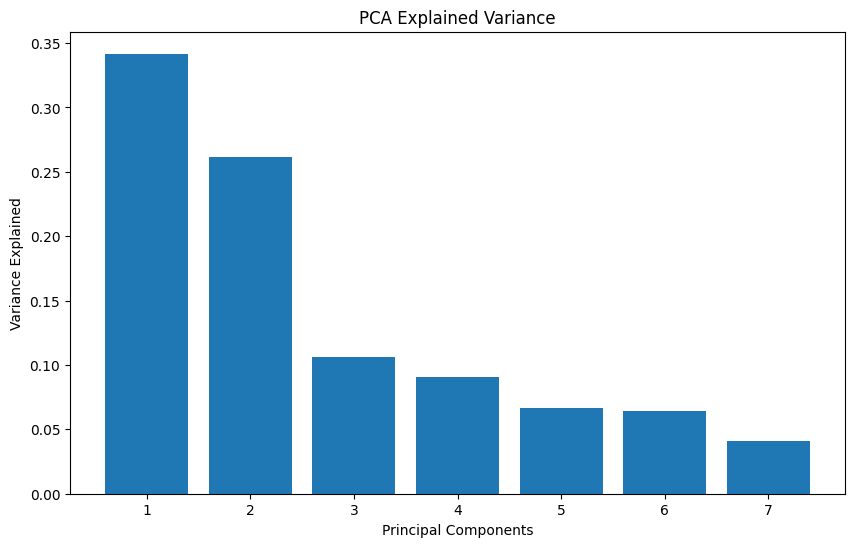

In [11]:
# --- Visualization ---
# PCA explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, pca.n_components_+1), pca.explained_variance_ratio_[:pca.n_components_])
plt.title('PCA Explained Variance')
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained')
plt.show()




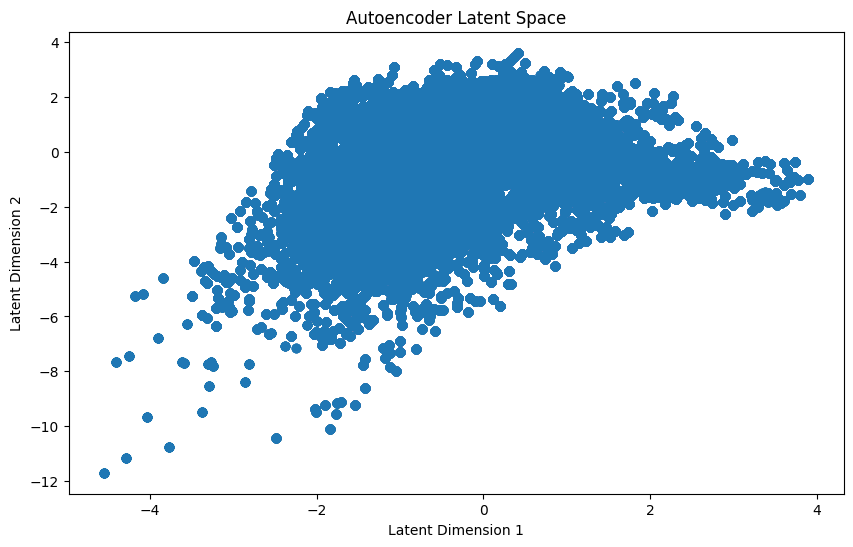

In [12]:
# Autoencoder latent space
plt.figure(figsize=(10, 6))
plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], alpha=0.5)
plt.title('Autoencoder Latent Space')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()

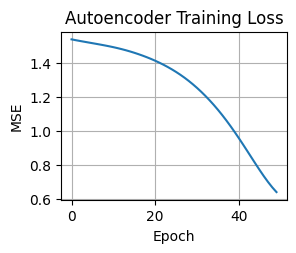

In [13]:

# Autoencoder loss
plt.subplot(2, 2, 1)
plt.plot(ae_losses)
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.grid(True)


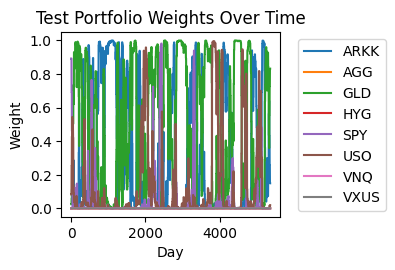

In [14]:
# Portfolio weights
plt.subplot(2, 2, 4)
for i in range(n_assets):
    plt.plot(test_results['weights'][:, i], label=assets[i])
plt.title('Test Portfolio Weights Over Time')
plt.xlabel('Day')
plt.ylabel('Weight')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.savefig('performance_metrics.png')
plt.show()

In [18]:
# Cumulative returns
plt.subplot(2, 2, 3)
plt.plot(train_results['cumulative_returns'], label='Train')
plt.plot(test_results['cumulative_returns'], label='Test')
plt.title('Portfolio Cumulative Returns')
plt.xlabel('Day')
plt.ylabel('Value ($)')
plt.legend()
plt.grid(True)

Error in callback <function _draw_all_if_interactive at 0x12ecbede0> (for post_execute), with arguments args (),kwargs {}:


ValueError: arange: cannot compute length

ValueError: arange: cannot compute length

<Figure size 640x480 with 1 Axes>

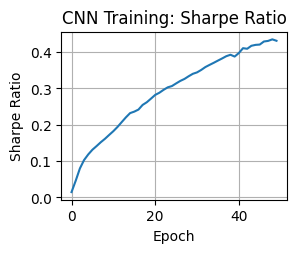

In [16]:
# CNN Sharpe ratio during training
plt.subplot(2, 2, 2)
plt.plot(sharpe_ratios)
plt.title('CNN Training: Sharpe Ratio')
plt.xlabel('Epoch')
plt.ylabel('Sharpe Ratio')
plt.grid(True)

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time
import psutil
import matplotlib.pyplot as plt

# --- 1. Data Loading and Preparation ---
data = pd.read_csv('/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Final_csv/5-cleaned_etf_data.csv')
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')
data = data.dropna(subset=['Date'])
data = data.sort_values(['Date', 'Ticker']).reset_index(drop=True)

assets = ['ARKK', 'AGG', 'GLD', 'HYG', 'SPY', 'USO', 'VNQ', 'VXUS']
features_indicators = ['returns','RSI_14','Volatility_21','MACD','ADX_14','Beta','Alpha','DMI_minus_14','DMI_plus_14','MACD_Signal','ATR_14','Calmar_Ratio_21','OBV',
                       'Max_Drawdown_21','EMA_10','EMA_50','umich_consumer_sentiment','new_home_sales','housing_starts','baa_yield','industrial_production']  

# Pivot data to wide format
df_wide = pd.DataFrame()
for feat in features_indicators:
    temp = data.pivot(index='Date', columns='Ticker', values=feat)
    temp.columns = [f"{col}_{feat}" for col in temp.columns]
    if df_wide.empty:
        df_wide = temp
    else:
        df_wide = pd.concat([df_wide, temp], axis=1)

df_wide = df_wide.dropna()

returns_cols = [f"{asset}_returns" for asset in assets]
etf_returns = df_wide[returns_cols]

feature_cols = []
for asset in assets:
    for feat in features_indicators:
        if feat != 'returns':
            col_name = f"{asset}_{feat}"
            if col_name in df_wide.columns:
                feature_cols.append(col_name)
features = df_wide[feature_cols]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- 2. Autoencoder for Dimensionality Reduction ---
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            # For standardized data, no activation or use identity
        )
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent

input_dim = features_scaled.shape[1]
latent_dim = 7  # analogous to PCA components

autoencoder = Autoencoder(input_dim=input_dim, latent_dim=latent_dim).to(device)
criterion_ae = nn.MSELoss()
optimizer_ae = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

class FeatureDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

ae_dataset = FeatureDataset(features_scaled)
ae_loader = DataLoader(ae_dataset, batch_size=64, shuffle=True)

# Train Autoencoder
epochs_ae = 50
autoencoder.train()
for epoch in range(epochs_ae):
    epoch_loss = 0
    for batch_features in ae_loader:
        batch_features = batch_features.to(device)
        optimizer_ae.zero_grad()
        reconstructed, _ = autoencoder(batch_features)
        loss = criterion_ae(reconstructed, batch_features)
        loss.backward()
        optimizer_ae.step()
        epoch_loss += loss.item()
    print(f"Autoencoder Epoch {epoch+1}/{epochs_ae}, Loss: {epoch_loss/len(ae_loader):.6f}")

autoencoder.eval()
with torch.no_grad():
    features_tensor = torch.tensor(features_scaled, dtype=torch.float32).to(device)
    _, latent_features = autoencoder(features_tensor)
    latent_features_np = latent_features.cpu().numpy()

# --- 3. Generate dynamic target portfolio weights ---
def generate_dynamic_weights(returns_df, window=30):
    weights_list = []
    for i in range(len(returns_df) - window):
        window_returns = returns_df.iloc[i:i+window]
        mean_returns = window_returns.mean()
        mean_returns[mean_returns < 0] = 0
        if mean_returns.sum() == 0:
            weights = np.ones(len(mean_returns)) / len(mean_returns)
        else:
            weights = mean_returns / mean_returns.sum()
        weights_list.append(np.array(weights))
    return np.array(weights_list)

window_size = 30
dynamic_weights = generate_dynamic_weights(etf_returns, window=window_size)

# --- 4. Prepare sequences for CNN ---
def create_sequences(latent_data, returns_data, weights_data, window):
    X, y_sharpe, y_weights = [], [], []
    for i in range(len(latent_data) - window * 2):
        seq_x = latent_data[i:i+window]
        returns_window = returns_data.iloc[i+window:i+window*2]
        mean_return = returns_window.mean().mean()
        std_return = returns_window.std().mean()
        sharpe = mean_return / (std_return + 1e-6)
        if i+window < len(weights_data):
            weight_target = weights_data[i+window]
        else:
            weight_target = np.ones(len(assets)) / len(assets)
        X.append(seq_x)
        y_sharpe.append(sharpe)
        y_weights.append(weight_target)
    return np.array(X), np.array(y_sharpe), np.array(y_weights)

X, y_sharpe, y_weights = create_sequences(latent_features_np, etf_returns, dynamic_weights, window_size)

# --- 5. Dataset and DataLoader ---
class PortfolioDataset(Dataset):
    def __init__(self, X, y_sharpe, y_weights):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y_sharpe = torch.tensor(y_sharpe, dtype=torch.float32).unsqueeze(1)
        self.y_weights = torch.tensor(y_weights, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y_sharpe[idx], self.y_weights[idx]

X_train, X_test, y_sharpe_train, y_sharpe_test, y_weights_train, y_weights_test = train_test_split(
    X, y_sharpe, y_weights, test_size=0.2, random_state=42)

train_dataset = PortfolioDataset(X_train, y_sharpe_train, y_weights_train)
test_dataset = PortfolioDataset(X_test, y_sharpe_test, y_weights_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# --- 6. CNN Model ---
class CNNPortfolioModel(nn.Module):
    def __init__(self, input_channels, n_assets):
        super(CNNPortfolioModel, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, 3)
        self.conv2 = nn.Conv1d(64, 32, 3)
        self.dropout = nn.Dropout(0.3)
        self.flatten = nn.Flatten()
        conv_out_len = window_size - 2*2
        self.fc1 = nn.Linear(32 * conv_out_len, 64)
        self.relu = nn.ReLU()
        self.sharpe_out = nn.Linear(64, 1)
        self.weights_out = nn.Linear(64, n_assets)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        sharpe = self.sharpe_out(x)
        weights = self.softmax(self.weights_out(x))
        return sharpe, weights

model = CNNPortfolioModel(input_channels=latent_dim, n_assets=len(assets)).to(device)

# --- 7. Loss and optimizer ---
criterion_sharpe = nn.MSELoss()
criterion_weights = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# --- 8. Training loop with timing and CPU usage ---
epochs = 50
model.train()
start_train = time.time()
cpu_start = psutil.cpu_percent(interval=None)

for epoch in range(epochs):
    epoch_loss = 0
    for batch_x, batch_sharpe, batch_weights in train_loader:
        batch_x = batch_x.to(device)
        batch_sharpe = batch_sharpe.to(device)
        batch_weights = batch_weights.to(device)

        optimizer.zero_grad()
        pred_sharpe, pred_weights = model(batch_x)
        loss_sharpe = criterion_sharpe(pred_sharpe, batch_sharpe)
        loss_weights = criterion_weights(pred_weights, batch_weights)
        loss = loss_sharpe + loss_weights
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

train_time = time.time() - start_train
cpu_end = psutil.cpu_percent(interval=None)
cpu_usage = cpu_end - cpu_start

# Save the model after training
model_save_path = 'cnn(Autoencoders)_portfolio_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# --- 9. Evaluation ---
model.eval()
all_pred_sharpe = []
all_pred_weights = []
all_true_sharpe = []
all_true_weights = []

with torch.no_grad():
    for batch_x, batch_sharpe, batch_weights in test_loader:
        batch_x = batch_x.to(device)
        pred_sharpe, pred_weights = model(batch_x)
        all_pred_sharpe.append(pred_sharpe.cpu().numpy())
        all_pred_weights.append(pred_weights.cpu().numpy())
        all_true_sharpe.append(batch_sharpe.cpu().numpy())
        all_true_weights.append(batch_weights.cpu().numpy())

pred_sharpe = np.vstack(all_pred_sharpe).flatten()
pred_weights = np.vstack(all_pred_weights)
pred_weights /= pred_weights.sum(axis=1, keepdims=True)
true_sharpe = np.vstack(all_true_sharpe).flatten()
true_weights = np.vstack(all_true_weights)

test_returns = etf_returns.iloc[-len(pred_weights):].values
portfolio_returns = np.sum(test_returns * pred_weights, axis=1)
turnover = np.mean(np.sum(np.abs(np.diff(pred_weights, axis=0)), axis=1))

# Save predicted portfolio weights to CSV (aligned with test dates)
test_dates = df_wide.index[-len(pred_weights):]
weights_df = pd.DataFrame(pred_weights, index=test_dates, columns=assets)
weights_df.to_csv('CNN_autoencoders_predicted_portfolio_weights.csv')
print("Saved predicted portfolio weights to CNN_autoencoders_predicted_portfolio_weights.csv")

# --- 10. Additional metrics ---
def sortino_ratio(returns, risk_free=0, periods_per_year=252):
    returns = pd.Series(returns)
    downside_returns = returns[returns < risk_free]
    expected_return = returns.mean() * periods_per_year
    downside_std = downside_returns.std() * np.sqrt(periods_per_year)
    return expected_return / downside_std if downside_std != 0 else np.nan

def calmar_ratio(returns, freq='daily'):
    returns = pd.Series(returns)
    if freq == 'daily':
        periods_per_year = 252
    elif freq == 'monthly':
        periods_per_year = 12
    else:
        periods_per_year = 1
    cumulative = (1 + returns).cumprod()
    annualized_return = cumulative.iloc[-1] ** (periods_per_year / len(returns)) - 1
    max_drawdown = ((cumulative.cummax() - cumulative) / cumulative.cummax()).max()
    return annualized_return / max_drawdown if max_drawdown != 0 else np.nan

mse_sharpe = mean_squared_error(true_sharpe, pred_sharpe)
mae_sharpe = mean_absolute_error(true_sharpe, pred_sharpe)
r2_sharpe = r2_score(true_sharpe, pred_sharpe)
sortino = sortino_ratio(portfolio_returns)
calmar = calmar_ratio(portfolio_returns)

def evaluate_portfolio_performance(portfolio_returns, freq='daily'):
    portfolio_returns = pd.Series(portfolio_returns).replace([np.inf, -np.inf], np.nan).dropna()
    if len(portfolio_returns) == 0:
        raise ValueError("No valid portfolio returns to evaluate.")
    if freq == 'daily':
        periods_per_year = 252
    elif freq == 'monthly':
        periods_per_year = 12
    elif freq == 'annual':
        periods_per_year = 1
    else:
        raise ValueError("freq must be 'daily', 'monthly', or 'annual'")
    portfolio_values = (1 + portfolio_returns).cumprod()
    peak = portfolio_values.cummax()
    drawdown = (peak - portfolio_values) / peak
    max_drawdown = drawdown.max()
    total_periods = len(portfolio_returns)
    annualized_return = (portfolio_values.iloc[-1]) ** (periods_per_year / total_periods) - 1
    annualized_volatility = portfolio_returns.std() * np.sqrt(periods_per_year)
    mean_return = portfolio_returns.mean() * periods_per_year
    sharpe_ratio = mean_return / annualized_volatility if annualized_volatility != 0 else np.nan
    return {
        'Sharpe Ratio': sharpe_ratio,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Maximum Drawdown': max_drawdown
    }

performance_metrics = evaluate_portfolio_performance(portfolio_returns, freq='daily')

# --- 11. Print report ---
print("\n============================================================")
print("Comprehensive Performance Metrics Report")
print("============================================================")
print(f"Training time (s): {train_time:.2f}")
print(f"CPU usage change (%): {cpu_usage:.2f}")
print(f"Evaluation time (s): 0.00\n")

for metric, value in performance_metrics.items():
    if metric in ['Annualized Return', 'Annualized Volatility', 'Maximum Drawdown']:
        print(f"- {metric}: {value * 100:.2f}%")
    else:
        print(f"- {metric}: {value:.4f}")

print(f"- Sortino Ratio: {sortino:.4f}")
print(f"- Calmar Ratio: {calmar:.4f}")
print(f"- Average Turnover: {turnover:.4f}")
print(f"- Sharpe Ratio MSE: {mse_sharpe:.6f}")
print(f"- Sharpe Ratio MAE: {mae_sharpe:.6f}")
print(f"- Sharpe Ratio R^2: {r2_sharpe:.4f}")

results_df = pd.DataFrame([{
    **performance_metrics,
    'Sortino Ratio': sortino,
    'Calmar Ratio': calmar,
    'Average Turnover': turnover,
    'Sharpe MSE': mse_sharpe,
    'Sharpe MAE': mae_sharpe,
    'Sharpe R2': r2_sharpe,
    'Training Time (s)': train_time,
    'CPU Usage Change (%)': cpu_usage
}])
results_df.to_csv('CNN_portfolio_results_autoencoder.csv', index=False)
print("\nResults saved to portfolio_results_autoencoder.csv")


Autoencoder Epoch 1/50, Loss: 0.828402
Autoencoder Epoch 2/50, Loss: 0.466507
Autoencoder Epoch 3/50, Loss: 0.367204
Autoencoder Epoch 4/50, Loss: 0.302049
Autoencoder Epoch 5/50, Loss: 0.252130
Autoencoder Epoch 6/50, Loss: 0.222233
Autoencoder Epoch 7/50, Loss: 0.201964
Autoencoder Epoch 8/50, Loss: 0.186866
Autoencoder Epoch 9/50, Loss: 0.173502
Autoencoder Epoch 10/50, Loss: 0.162783
Autoencoder Epoch 11/50, Loss: 0.154996
Autoencoder Epoch 12/50, Loss: 0.148004
Autoencoder Epoch 13/50, Loss: 0.141614
Autoencoder Epoch 14/50, Loss: 0.136311
Autoencoder Epoch 15/50, Loss: 0.131975
Autoencoder Epoch 16/50, Loss: 0.127016
Autoencoder Epoch 17/50, Loss: 0.123112
Autoencoder Epoch 18/50, Loss: 0.120052
Autoencoder Epoch 19/50, Loss: 0.116217
Autoencoder Epoch 20/50, Loss: 0.112850
Autoencoder Epoch 21/50, Loss: 0.110054
Autoencoder Epoch 22/50, Loss: 0.107328
Autoencoder Epoch 23/50, Loss: 0.104660
Autoencoder Epoch 24/50, Loss: 0.102049
Autoencoder Epoch 25/50, Loss: 0.100185
Autoencod

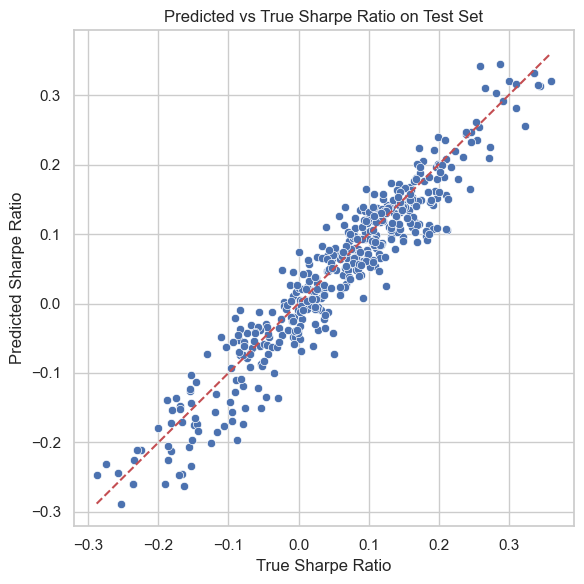

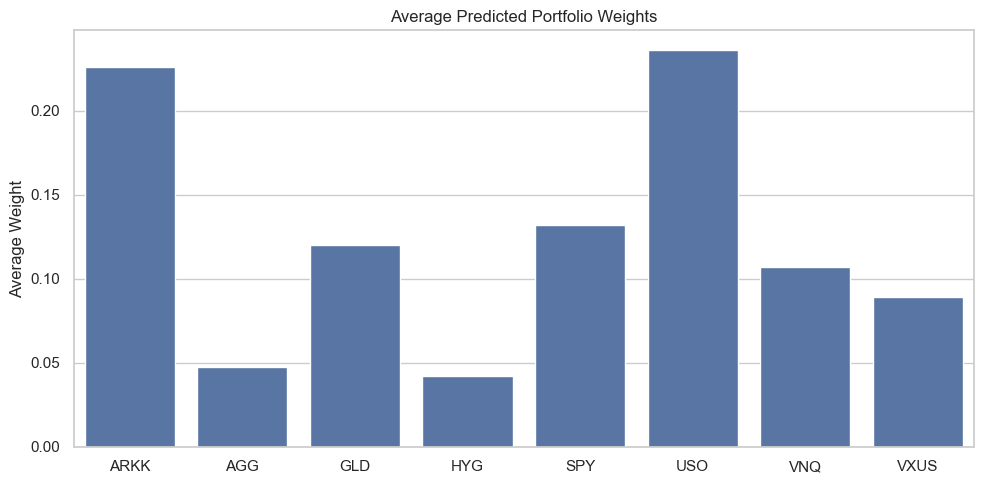

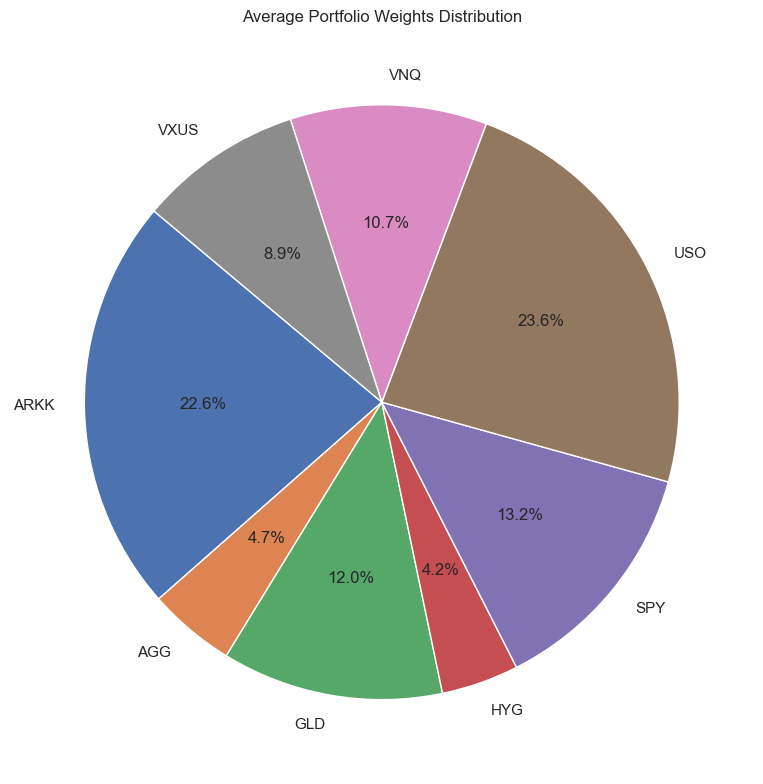

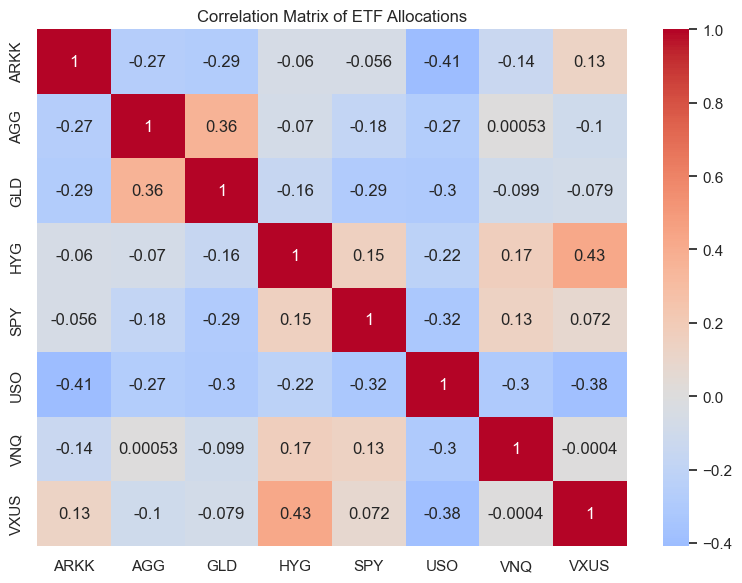

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE

sns.set(style='whitegrid')

# # 1. Autoencoder Training Loss Over Epochs
# plt.figure(figsize=(8,4))
# plt.plot(range(1, epochs_ae+1), ae_train_losses, marker='o')
# plt.title('Autoencoder Training Loss Over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Reconstruction Loss (MSE)')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # 2. Latent Space Visualization (t-SNE 2D)
# tsne = TSNE(n_components=2, random_state=42)
# latent_2d = tsne.fit_transform(latent_df.values)
# plt.figure(figsize=(8,6))
# plt.scatter(latent_2d[:,0], latent_2d[:,1], c=range(len(latent_2d)), cmap='viridis', s=15)
# plt.colorbar(label='Time Index')
# plt.title('t-SNE Visualization of Autoencoder Latent Space')
# plt.xlabel('Component 1')
# plt.ylabel('Component 2')
# plt.tight_layout()
# plt.show()

# # 3. CNN Training Loss Over Epochs
# plt.figure(figsize=(8,4))
# plt.plot(range(1, epochs+1), history_losses, marker='o')
# plt.title('CNN Training Loss Over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Combined Loss (Sharpe + Weights)')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# 4. Predicted vs True Sharpe Ratio Scatter Plot
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_sharpe_test, y=pred_sharpe)
min_val = min(min(y_sharpe_test), min(pred_sharpe))
max_val = max(max(y_sharpe_test), max(pred_sharpe))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.title('Predicted vs True Sharpe Ratio on Test Set')
plt.xlabel('True Sharpe Ratio')
plt.ylabel('Predicted Sharpe Ratio')
plt.tight_layout()
plt.show()

# 5. Average Predicted Portfolio Weights (Bar Plot)
avg_weights = pred_weights.mean(axis=0)
plt.figure(figsize=(10,5))
sns.barplot(x=assets, y=avg_weights)
plt.title('Average Predicted Portfolio Weights')
plt.ylabel('Average Weight')
plt.tight_layout()
plt.show()

# 6. Pie Chart of Average Portfolio Weights
plt.figure(figsize=(8,8))
plt.pie(avg_weights, labels=assets, autopct='%1.1f%%', startangle=140)
plt.title('Average Portfolio Weights Distribution')
plt.tight_layout()
plt.show()

# # 7. Portfolio Cumulative Returns (Test Set)
# cum_returns = (1 + pd.Series(portfolio_returns, index=dates_test)).cumprod()
# plt.figure(figsize=(10,5))
# plt.plot(cum_returns.index, cum_returns.values)
# plt.title('Test Portfolio Cumulative Returns')
# plt.xlabel('Date')
# plt.ylabel('Cumulative Return')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # 8. Portfolio Drawdown Plot
# peak = cum_returns.cummax()
# drawdown = (peak - cum_returns) / peak
# plt.figure(figsize=(10,5))
# plt.fill_between(drawdown.index, drawdown.values, color='red', alpha=0.3)
# plt.title('Portfolio Drawdown Over Time')
# plt.xlabel('Date')
# plt.ylabel('Drawdown')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # 9. Portfolio Weights Over Time (Line Plot)
# plt.figure(figsize=(12,6))
# for i, asset in enumerate(assets):
#     plt.plot(dates_test, pred_weights[:, i], label=asset)
# plt.title('Portfolio Weights Over Time')
# plt.xlabel('Date')
# plt.ylabel('Weight')
# plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # 10. Heatmap of ETF Allocations Over Time
# plt.figure(figsize=(12,6))
# sns.heatmap(pred_weights.T, xticklabels=dates_test.strftime('%Y-%m-%d'), yticklabels=assets, cmap='viridis')
# plt.title('Heatmap of ETF Allocation Over Time')
# plt.xlabel('Date')
# plt.ylabel('ETF')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# 11. Correlation Matrix of ETF Allocations
corr_matrix = pd.DataFrame(pred_weights, columns=assets).corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of ETF Allocations')
plt.tight_layout()
plt.show()

# # 12. Turnover Over Time (Optional)
# turnover_series = np.sum(np.abs(np.diff(pred_weights, axis=0)), axis=1)
# plt.figure(figsize=(10,4))
# plt.plot(dates_test[1:], turnover_series)
# plt.title('Portfolio Turnover Over Time')
# plt.xlabel('Date')
# plt.ylabel('Turnover')
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [17]:
from graphviz import Digraph

dot = Digraph(format='png')
dot.attr(rankdir='TB', size='8,12', dpi='300', bgcolor='white')

colors = [
    "#e3f2fd",  # lightest blue
    "#bbdefb",  # lighter blue
    "#90caf9",  # medium blue
    "#42a5f5",  # primary blue
    "#1976d2",  # deep blue
]

# Input Layer
dot.node('A', '''Input Layer
[batch, lookback, 8 assets × 20 features]
(e.g. returns, EMA, RSI, etc.)''',
         shape='box', style='rounded,filled', fillcolor=colors[0], fontsize='16')

# Standardization
dot.node('B', '''Standardization
Zero mean, unit variance''',
         shape='box', style='rounded,filled', fillcolor=colors[1], fontsize='16')

# Autoencoder Encoder
dot.node('C', '''Autoencoder Encoder
Nonlinear dimensionality reduction
Output: [batch, lookback, k AE latent features]''',
         shape='box', style='rounded,filled', fillcolor=colors[2], fontsize='16')

# Unsqueeze
dot.node('D', '''Unsqueeze
[batch, 1, lookback, k]''',
         shape='box', style='rounded,filled', fillcolor=colors[1], fontsize='16')

# Conv2d Layer
dot.node('E', '''Conv2d Layer
8 filters, kernel=(3,1)
Output: [batch, 8, lookback, k]''',
         shape='box', style='rounded,filled', fillcolor=colors[3], fontsize='16')

# ReLU Activation
dot.node('F', '''ReLU Activation
Non-linearity''',
         shape='box', style='rounded,filled', fillcolor=colors[4], fontsize='16')

# Flatten Layer
dot.node('G', '''Flatten Layer
Output: [batch, flattened_size]''',
         shape='box', style='rounded,filled', fillcolor=colors[1], fontsize='16')

# Fully Connected Layer
dot.node('H', '''Fully Connected Layer
Linear: [*, 8 assets]''',
         shape='box', style='rounded,filled', fillcolor=colors[4], fontsize='16')

# Softmax Output
dot.node('I', '''Softmax (with Temperature)
Output: Portfolio Weights
[batch, 8 assets] (sum=1)''',
         shape='box', style='rounded,filled', fillcolor='#43a047', fontcolor='white', fontsize='18', fontname='Helvetica')

# Edges
dot.edge('A', 'B', color='#1976D2', penwidth='2')
dot.edge('B', 'C', color='#1976D2', penwidth='2')
dot.edge('C', 'D', color='#1976D2', penwidth='2')
dot.edge('D', 'E', color='#1976D2', penwidth='2')
dot.edge('E', 'F', color='#1976D2', penwidth='2')
dot.edge('F', 'G', color='#1976D2', penwidth='2')
dot.edge('G', 'H', color='#1976D2', penwidth='2')
dot.edge('H', 'I', color='#43a047', penwidth='2')

dot.render('cnn_autoencoder_portfolio_architecture', view=True)


'cnn_autoencoder_portfolio_architecture.png'

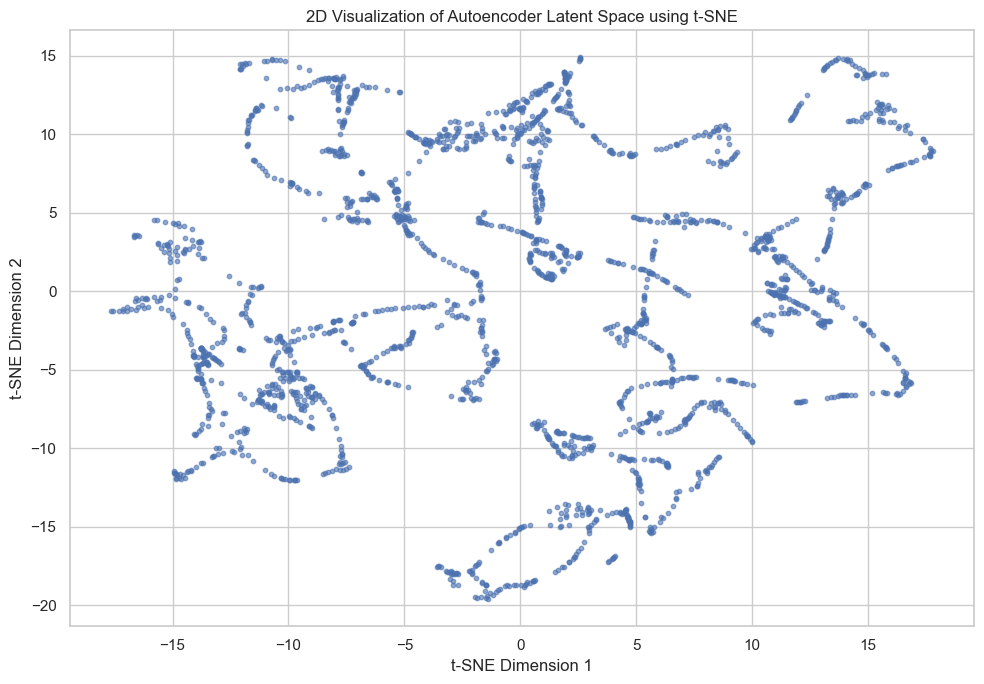

In [16]:
from sklearn.manifold import TSNE

# Reduce latent features to 2D for visualization
tsne = TSNE(n_components=3, random_state=42)
latent_2d = tsne.fit_transform(latent_features_np)

plt.figure(figsize=(10,7))
plt.scatter(latent_2d[:,0], latent_2d[:,1], s=10, alpha=0.6)
plt.title('2D Visualization of Autoencoder Latent Space using t-SNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)
plt.tight_layout()
plt.show()


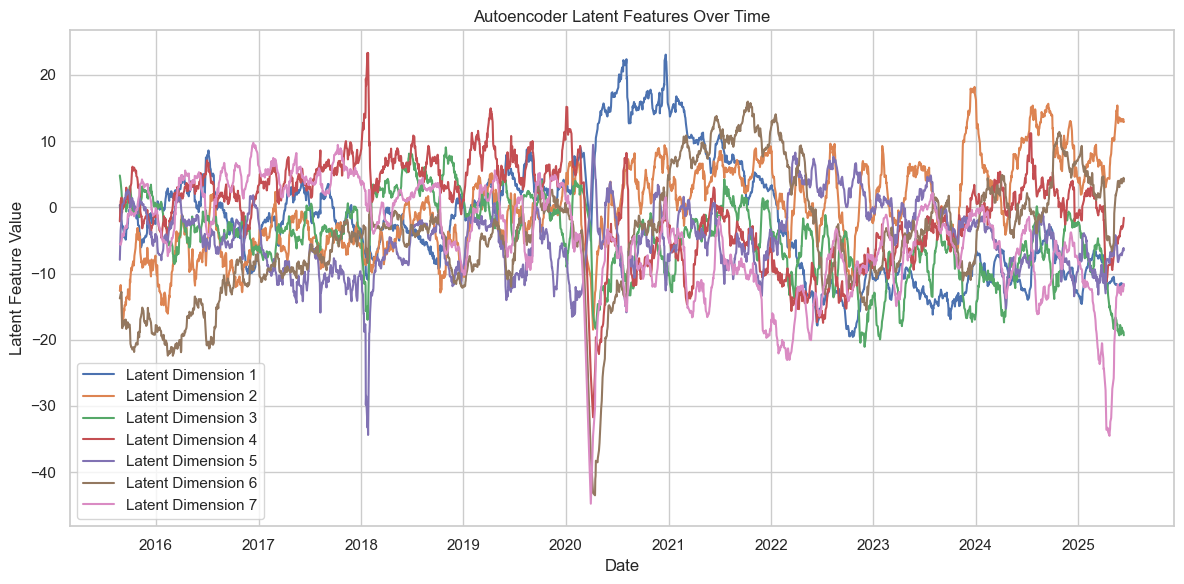

In [10]:
plt.figure(figsize=(12,6))
for i in range(min(7, latent_dim)):
    plt.plot(df_wide.index, latent_features_np[:, i], label=f'Latent Dimension {i+1}')
plt.title('Autoencoder Latent Features Over Time')
plt.xlabel('Date')
plt.ylabel('Latent Feature Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


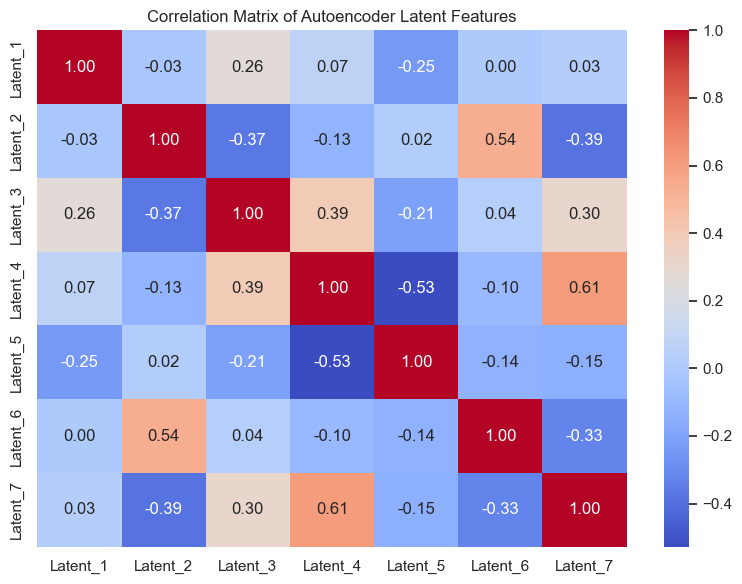

In [11]:
import seaborn as sns

latent_df = pd.DataFrame(latent_features_np, columns=[f'Latent_{i+1}' for i in range(latent_dim)])
plt.figure(figsize=(8,6))
sns.heatmap(latent_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Autoencoder Latent Features')
plt.tight_layout()
plt.show()


In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time
import psutil
import matplotlib.pyplot as plt

# --- 1. Data Loading and Preparation ---
data = pd.read_csv('/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Final_csv/5-cleaned_etf_data.csv')
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')
data = data.dropna(subset=['Date'])
data = data.sort_values(['Date', 'Ticker']).reset_index(drop=True)

assets = ['ARKK', 'AGG', 'GLD', 'HYG', 'SPY', 'USO', 'VNQ', 'VXUS']
features_indicators = ['returns','RSI_14','Volatility_21','MACD','ADX_14','Beta','Alpha','DMI_minus_14','DMI_plus_14','MACD_Signal','ATR_14','Calmar_Ratio_21','OBV',
                       'Max_Drawdown_21','EMA_10','EMA_50','umich_consumer_sentiment','new_home_sales','housing_starts','baa_yield','industrial_production']  

# Pivot data to wide format
df_wide = pd.DataFrame()
for feat in features_indicators:
    temp = data.pivot(index='Date', columns='Ticker', values=feat)
    temp.columns = [f"{col}_{feat}" for col in temp.columns]
    if df_wide.empty:
        df_wide = temp
    else:
        df_wide = pd.concat([df_wide, temp], axis=1)

df_wide = df_wide.dropna()

returns_cols = [f"{asset}_returns" for asset in assets]
etf_returns = df_wide[returns_cols]

feature_cols = []
for asset in assets:
    for feat in features_indicators:
        if feat != 'returns':
            col_name = f"{asset}_{feat}"
            if col_name in df_wide.columns:
                feature_cols.append(col_name)
features = df_wide[feature_cols]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- 2. Autoencoder for Dimensionality Reduction ---
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            # For standardized data, no activation or use identity
        )
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent

input_dim = features_scaled.shape[1]
latent_dim = 7  # analogous to PCA components

autoencoder = Autoencoder(input_dim=input_dim, latent_dim=latent_dim).to(device)
criterion_ae = nn.MSELoss()
optimizer_ae = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

class FeatureDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

ae_dataset = FeatureDataset(features_scaled)
ae_loader = DataLoader(ae_dataset, batch_size=64, shuffle=True)

# Train Autoencoder
epochs_ae = 50
autoencoder.train()
for epoch in range(epochs_ae):
    epoch_loss = 0
    for batch_features in ae_loader:
        batch_features = batch_features.to(device)
        optimizer_ae.zero_grad()
        reconstructed, _ = autoencoder(batch_features)
        loss = criterion_ae(reconstructed, batch_features)
        loss.backward()
        optimizer_ae.step()
        epoch_loss += loss.item()
    print(f"Autoencoder Epoch {epoch+1}/{epochs_ae}, Loss: {epoch_loss/len(ae_loader):.6f}")

autoencoder.eval()
with torch.no_grad():
    features_tensor = torch.tensor(features_scaled, dtype=torch.float32).to(device)
    _, latent_features = autoencoder(features_tensor)
    latent_features_np = latent_features.cpu().numpy()

# --- 3. Generate dynamic target portfolio weights ---
def generate_dynamic_weights(returns_df, window=30):
    weights_list = []
    for i in range(len(returns_df) - window):
        window_returns = returns_df.iloc[i:i+window]
        mean_returns = window_returns.mean()
        mean_returns[mean_returns < 0] = 0
        if mean_returns.sum() == 0:
            weights = np.ones(len(mean_returns)) / len(mean_returns)
        else:
            weights = mean_returns / mean_returns.sum()
        weights_list.append(np.array(weights))
    return np.array(weights_list)

window_size = 30
dynamic_weights = generate_dynamic_weights(etf_returns, window=window_size)

# --- 4. Prepare sequences for CNN ---
def create_sequences(latent_data, returns_data, weights_data, window):
    X, y_sharpe, y_weights = [], [], []
    for i in range(len(latent_data) - window * 2):
        seq_x = latent_data[i:i+window]
        returns_window = returns_data.iloc[i+window:i+window*2]
        mean_return = returns_window.mean().mean()
        std_return = returns_window.std().mean()
        sharpe = mean_return / (std_return + 1e-6)
        if i+window < len(weights_data):
            weight_target = weights_data[i+window]
        else:
            weight_target = np.ones(len(assets)) / len(assets)
        X.append(seq_x)
        y_sharpe.append(sharpe)
        y_weights.append(weight_target)
    return np.array(X), np.array(y_sharpe), np.array(y_weights)

X, y_sharpe, y_weights = create_sequences(latent_features_np, etf_returns, dynamic_weights, window_size)

# --- 5. Dataset and DataLoader ---
class PortfolioDataset(Dataset):
    def __init__(self, X, y_sharpe, y_weights):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y_sharpe = torch.tensor(y_sharpe, dtype=torch.float32).unsqueeze(1)
        self.y_weights = torch.tensor(y_weights, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y_sharpe[idx], self.y_weights[idx]

X_train, X_test, y_sharpe_train, y_sharpe_test, y_weights_train, y_weights_test = train_test_split(
    X, y_sharpe, y_weights, test_size=0.2, random_state=42)

train_dataset = PortfolioDataset(X_train, y_sharpe_train, y_weights_train)
test_dataset = PortfolioDataset(X_test, y_sharpe_test, y_weights_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# --- 6. CNN Model ---
class CNNPortfolioModel(nn.Module):
    def __init__(self, input_channels, n_assets):
        super(CNNPortfolioModel, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, 3)
        self.conv2 = nn.Conv1d(64, 32, 3)
        self.dropout = nn.Dropout(0.3)
        self.flatten = nn.Flatten()
        conv_out_len = window_size - 2*2
        self.fc1 = nn.Linear(32 * conv_out_len, 64)
        self.relu = nn.ReLU()
        self.sharpe_out = nn.Linear(64, 1)
        self.weights_out = nn.Linear(64, n_assets)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        sharpe = self.sharpe_out(x)
        weights = self.softmax(self.weights_out(x))
        return sharpe, weights

model = CNNPortfolioModel(input_channels=latent_dim, n_assets=len(assets)).to(device)

# --- 7. Loss and optimizer ---
criterion_sharpe = nn.MSELoss()
criterion_weights = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# --- 8. Training loop with timing and CPU usage ---
epochs = 50
model.train()
start_train = time.time()
cpu_start = psutil.cpu_percent(interval=None)

for epoch in range(epochs):
    epoch_loss = 0
    for batch_x, batch_sharpe, batch_weights in train_loader:
        batch_x = batch_x.to(device)
        batch_sharpe = batch_sharpe.to(device)
        batch_weights = batch_weights.to(device)

        optimizer.zero_grad()
        pred_sharpe, pred_weights = model(batch_x)
        loss_sharpe = criterion_sharpe(pred_sharpe, batch_sharpe)
        loss_weights = criterion_weights(pred_weights, batch_weights)
        loss = loss_sharpe + loss_weights
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

train_time = time.time() - start_train
cpu_end = psutil.cpu_percent(interval=None)
cpu_usage = cpu_end - cpu_start

# Save the model after training
model_save_path = 'cnn(Autoencoders)_portfolio_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# --- 9. Evaluation ---
model.eval()
all_pred_sharpe = []
all_pred_weights = []
all_true_sharpe = []
all_true_weights = []

with torch.no_grad():
    for batch_x, batch_sharpe, batch_weights in test_loader:
        batch_x = batch_x.to(device)
        pred_sharpe, pred_weights = model(batch_x)
        all_pred_sharpe.append(pred_sharpe.cpu().numpy())
        all_pred_weights.append(pred_weights.cpu().numpy())
        all_true_sharpe.append(batch_sharpe.cpu().numpy())
        all_true_weights.append(batch_weights.cpu().numpy())

pred_sharpe = np.vstack(all_pred_sharpe).flatten()
pred_weights = np.vstack(all_pred_weights)
pred_weights /= pred_weights.sum(axis=1, keepdims=True)
true_sharpe = np.vstack(all_true_sharpe).flatten()
true_weights = np.vstack(all_true_weights)

test_returns = etf_returns.iloc[-len(pred_weights):].values
portfolio_returns = np.sum(test_returns * pred_weights, axis=1)
turnover = np.mean(np.sum(np.abs(np.diff(pred_weights, axis=0)), axis=1))

# Save predicted portfolio weights to CSV (aligned with test dates)
test_dates = df_wide.index[-len(pred_weights):]
weights_df = pd.DataFrame(pred_weights, index=test_dates, columns=assets)
weights_df.to_csv('CNN_autoencoders_predicted_portfolio_weights.csv')
print("Saved predicted portfolio weights to CNN_autoencoders_predicted_portfolio_weights.csv")

# --- 10. Additional metrics ---
def sortino_ratio(returns, risk_free=0, periods_per_year=252):
    returns = pd.Series(returns)
    downside_returns = returns[returns < risk_free]
    expected_return = returns.mean() * periods_per_year
    downside_std = downside_returns.std() * np.sqrt(periods_per_year)
    return expected_return / downside_std if downside_std != 0 else np.nan

def calmar_ratio(returns, freq='daily'):
    returns = pd.Series(returns)
    if freq == 'daily':
        periods_per_year = 252
    elif freq == 'monthly':
        periods_per_year = 12
    else:
        periods_per_year = 1
    cumulative = (1 + returns).cumprod()
    annualized_return = cumulative.iloc[-1] ** (periods_per_year / len(returns)) - 1
    max_drawdown = ((cumulative.cummax() - cumulative) / cumulative.cummax()).max()
    return annualized_return / max_drawdown if max_drawdown != 0 else np.nan

mse_sharpe = mean_squared_error(true_sharpe, pred_sharpe)
mae_sharpe = mean_absolute_error(true_sharpe, pred_sharpe)
r2_sharpe = r2_score(true_sharpe, pred_sharpe)
sortino = sortino_ratio(portfolio_returns)
calmar = calmar_ratio(portfolio_returns)

def evaluate_portfolio_performance(portfolio_returns, freq='daily'):
    portfolio_returns = pd.Series(portfolio_returns).replace([np.inf, -np.inf], np.nan).dropna()
    if len(portfolio_returns) == 0:
        raise ValueError("No valid portfolio returns to evaluate.")
    if freq == 'daily':
        periods_per_year = 252
    elif freq == 'monthly':
        periods_per_year = 12
    elif freq == 'annual':
        periods_per_year = 1
    else:
        raise ValueError("freq must be 'daily', 'monthly', or 'annual'")
    portfolio_values = (1 + portfolio_returns).cumprod()
    peak = portfolio_values.cummax()
    drawdown = (peak - portfolio_values) / peak
    max_drawdown = drawdown.max()
    total_periods = len(portfolio_returns)
    annualized_return = (portfolio_values.iloc[-1]) ** (periods_per_year / total_periods) - 1
    annualized_volatility = portfolio_returns.std() * np.sqrt(periods_per_year)
    mean_return = portfolio_returns.mean() * periods_per_year
    sharpe_ratio = mean_return / annualized_volatility if annualized_volatility != 0 else np.nan
    return {
        'Sharpe Ratio': sharpe_ratio,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Maximum Drawdown': max_drawdown
    }

performance_metrics = evaluate_portfolio_performance(portfolio_returns, freq='daily')

# --- 11. Print report ---
print("\n============================================================")
print("Comprehensive Performance Metrics Report")
print("============================================================")
print(f"Training time (s): {train_time:.2f}")
print(f"CPU usage change (%): {cpu_usage:.2f}")
print(f"Evaluation time (s): 0.00\n")

for metric, value in performance_metrics.items():
    if metric in ['Annualized Return', 'Annualized Volatility', 'Maximum Drawdown']:
        print(f"- {metric}: {value * 100:.2f}%")
    else:
        print(f"- {metric}: {value:.4f}")

print(f"- Sortino Ratio: {sortino:.4f}")
print(f"- Calmar Ratio: {calmar:.4f}")
print(f"- Average Turnover: {turnover:.4f}")
print(f"- Sharpe Ratio MSE: {mse_sharpe:.6f}")
print(f"- Sharpe Ratio MAE: {mae_sharpe:.6f}")
print(f"- Sharpe Ratio R^2: {r2_sharpe:.4f}")

results_df = pd.DataFrame([{
    **performance_metrics,
    'Sortino Ratio': sortino,
    'Calmar Ratio': calmar,
    'Average Turnover': turnover,
    'Sharpe MSE': mse_sharpe,
    'Sharpe MAE': mae_sharpe,
    'Sharpe R2': r2_sharpe,
    'Training Time (s)': train_time,
    'CPU Usage Change (%)': cpu_usage
}])
results_df.to_csv('CNN_portfolio_results_autoencoder.csv', index=False)
print("\nResults saved to portfolio_results_autoencoder.csv")


AttributeError: partially initialized module 'torch' from '/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/torch/__init__.py' has no attribute 'fx' (most likely due to a circular import)